# Proje: Enron Veri Seti ile NLP Tabanlı Spam Tespiti

## 1. Giriş ve Amaç
Bu projenin amacı, Enron e-posta veri setini kullanarak e-postaların içeriğine göre "Spam" (istenmeyen) veya "Ham" (normal) olduğunu tespit eden bir makine öğrenmesi modeli geliştirmektir.

Proje kapsamında:
1. Veri temizleme ve ön işleme,
2. Metin madenciliği (TF-IDF),
3. Logistic Regression ve Naive Bayes algoritmalarıyla modelleme,
4. Modellerin ROC analizi ve detaylı performans kıyaslaması yapılacaktır.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve, 
    auc
)

# Uyarıları kapatmak için
import warnings
warnings.filterwarnings("ignore")

## 2. Veri Setinin Yüklenmesi ve Temizlenmesi
Veri seti yüklenir, gereksiz boşluklar temizlenir ve eksik veriler (null values) veri setinden çıkarılır.

In [2]:
# Veriyi oku
df = pd.read_csv("enron_spam_data.csv")

# Sütun isimlerindeki baş/son boşlukları temizle
df.rename(columns=lambda x: x.strip(), inplace=True)

# Eksik verileri ve tekrarlanan satırları temizle
df = df.dropna(subset=["Subject", "Message"])
df = df.drop_duplicates()

# Subject ve Message alanlarını birleştirip tek bir 'text' sütunu oluştur
df["text"] = df["Subject"].fillna("") + " " + df["Message"].fillna("")

# Etiketleme: spam=1, ham=0
df["label"] = df["Spam/Ham"].map({"ham": 0, "spam": 1})

print("Veri Seti Boyutu:", df.shape)
print(df.head())

Veri Seti Boyutu: (30184, 6)
                        Subject  \
1      vastar resources , inc .   
2  calpine daily gas nomination   
3                    re : issue   
4     meter 7268 nov allocation   
5      mcmullen gas for 11 / 99   

                                             Message Spam/Ham        Date  \
1  gary , production from the high island larger ...      ham  1999-12-13   
2             - calpine daily gas nomination 1 . doc      ham  1999-12-14   
3  fyi - see note below - already done .\nstella\...      ham  1999-12-14   
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...      ham  1999-12-14   
5  jackie ,\nsince the inlet to 3 river plant is ...      ham  1999-12-14   

                                                text  label  
1  vastar resources , inc . gary , production fro...      0  
2  calpine daily gas nomination - calpine daily g...      0  
3  re : issue fyi - see note below - already done...      0  
4  meter 7268 nov allocation fyi .\n- - - - - - -

## 3. Keşifçi Veri Analizi (EDA)
Bu bölümde veri setindeki sınıf dağılımı (dengesizlik var mı?) ve metin uzunluklarının dağılımı incelenir.

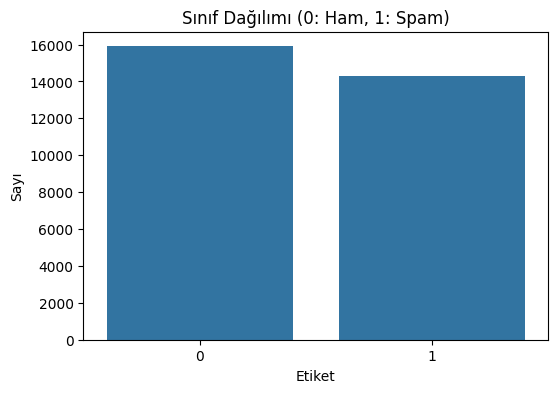

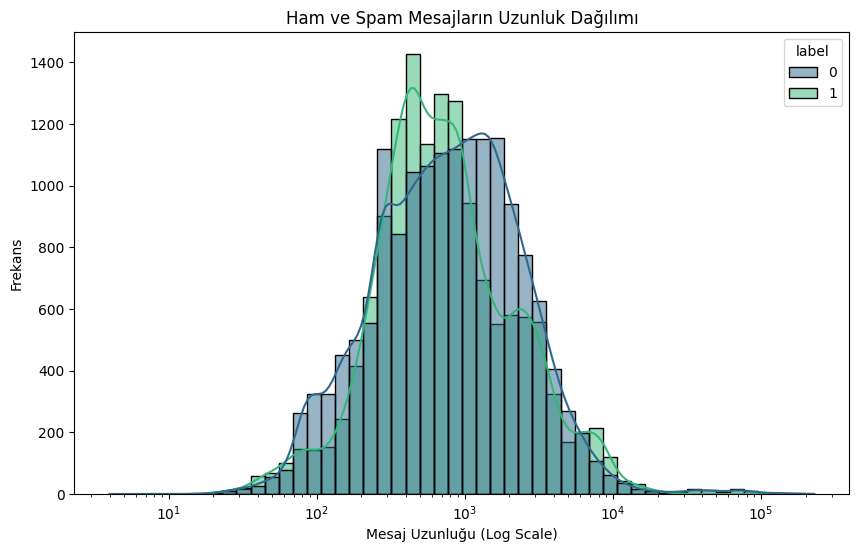

Ortalama Ham Mesaj Uzunluğu: 1627.5998993773976
Ortalama Spam Mesaj Uzunluğu: 1331.2643702303437


In [3]:
# 1. Sınıf Dağılımı Grafiği
plt.figure(figsize=(6,4))
sns.countplot(x=df['label'])
plt.title("Sınıf Dağılımı (0: Ham, 1: Spam)")
plt.xlabel("Etiket")
plt.ylabel("Sayı")
plt.show()

# 2. Metin Uzunluğu Analizi
# Temiz metin öncesi ham uzunluklara bakalım
df['text_len'] = df['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_len', hue='label', bins=50, kde=True, log_scale=True, palette='viridis')
plt.title('Ham ve Spam Mesajların Uzunluk Dağılımı')
plt.xlabel('Mesaj Uzunluğu (Log Scale)')
plt.ylabel('Frekans')
plt.show()

print("Ortalama Ham Mesaj Uzunluğu:", df[df['label'] == 0]['text_len'].mean())
print("Ortalama Spam Mesaj Uzunluğu:", df[df['label'] == 1]['text_len'].mean())

## 4. Veri Ön İşleme (Preprocessing)
NLP modellerinin daha iyi çalışması için metinler temizlenir:
* Küçük harfe çevirme
* URL ve özel karakter temizliği
* Gereksiz boşlukların silinmesi

In [4]:
def clean_text(text):
    text = str(text).lower()                         # küçük harf
    text = re.sub(r"http\S+|www\.\S+", " ", text)    # URL temizle
    text = re.sub(r"[^a-z\s]", " ", text)            # harf olmayan her şeyi kaldır
    text = re.sub(r"\s+", " ", text).strip()         # fazla boşlukları sil
    return text

df["clean_text"] = df["text"].apply(clean_text)

# Eğitim ve Test olarak ayırma (%80 Train, %20 Test)
X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Eğitim Verisi: {X_train.shape}, Test Verisi: {X_test.shape}")

Eğitim Verisi: (24147,), Test Verisi: (6037,)


## 5. Modelleme
Bu aşamada iki farklı algoritma kurulacaktır:
1. **Logistic Regression:** TF-IDF (n-gram 1,2) ile özellik çıkarımı.
2. **Multinomial Naive Bayes:** TF-IDF ile özellik çıkarımı.

In [5]:
# --- Model 1: Logistic Regression Pipeline ---
logreg_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words="english")),
    ("clf", LogisticRegression(max_iter=1000))
])

logreg_pipeline.fit(X_train, y_train)
y_pred_lr = logreg_pipeline.predict(X_test)

# --- Model 2: Naive Bayes Pipeline ---
nb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=5000, stop_words="english")),
    ("clf", MultinomialNB())
])

nb_pipeline.fit(X_train, y_train)
y_pred_nb = nb_pipeline.predict(X_test)

print("Modeller eğitildi.")

Modeller eğitildi.


## 6. Sonuçlar ve Değerlendirme
Her iki modelin Accuracy, Precision, Recall ve F1-Score değerleri incelenir. Ayrıca Confusion Matrix ve ROC Eğrisi çizdirilir.

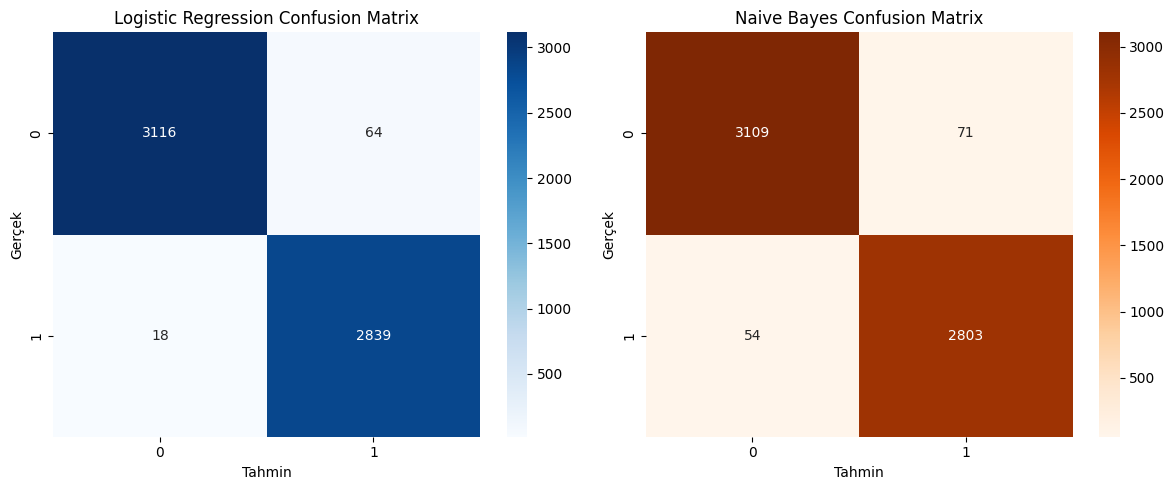

In [6]:
# Confusion Matrix Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression CM
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression Confusion Matrix')
axes[0].set_xlabel('Tahmin')
axes[0].set_ylabel('Gerçek')

# Naive Bayes CM
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('Naive Bayes Confusion Matrix')
axes[1].set_xlabel('Tahmin')
axes[1].set_ylabel('Gerçek')

plt.tight_layout()
plt.show()

### 6.1 ROC Eğrisi ve AUC Analizi
Modellerin sınıflandırma başarısını eşik değerden bağımsız ölçmek için ROC eğrisi kullanılır.

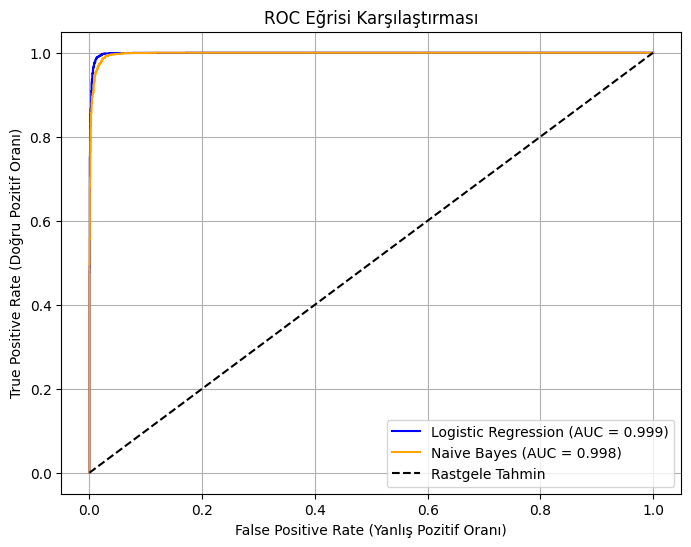

In [7]:
# Olasılık değerlerini al
y_prob_lr = logreg_pipeline.predict_proba(X_test)[:, 1]
y_prob_nb = nb_pipeline.predict_proba(X_test)[:, 1]

# ROC Eğrilerini hesapla
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

# Grafiği Çiz
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})', color='blue')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.3f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='Rastgele Tahmin')
plt.xlabel('False Positive Rate (Yanlış Pozitif Oranı)')
plt.ylabel('True Positive Rate (Doğru Pozitif Oranı)')
plt.title('ROC Eğrisi Karşılaştırması')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### 6.2 Modellerin Performans Karşılaştırma Tablosu
Tüm metriklerin yan yana kıyaslanması.

                 Model  Accuracy  Precision    Recall  F1 Score  AUC Score
0  Logistic Regression  0.986417   0.977954  0.993700  0.985764   0.998736
1          Naive Bayes  0.979294   0.975296  0.981099  0.978189   0.997844


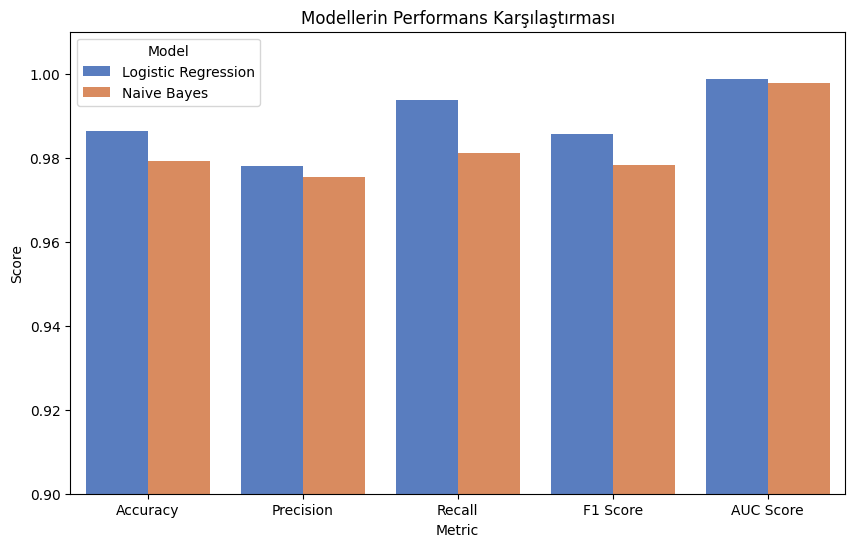

In [8]:
# Sonuçları DataFrame'e dökme
results = {
    'Model': ['Logistic Regression', 'Naive Bayes'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_nb)],
    'Precision': [precision_score(y_test, y_pred_lr), precision_score(y_test, y_pred_nb)],
    'Recall': [recall_score(y_test, y_pred_lr), recall_score(y_test, y_pred_nb)],
    'F1 Score': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_nb)],
    'AUC Score': [roc_auc_lr, roc_auc_nb]
}

df_results = pd.DataFrame(results)
print(df_results)

# Görselleştirme
df_melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted, palette="muted")
plt.title("Modellerin Performans Karşılaştırması")
plt.ylim(0.90, 1.01) # Farkları net görmek için zoom yapıldı
plt.show()

## 7. Gerçek Hayat Testi
Modelin daha önce görmediği örnek cümleler ile testi.

In [21]:
examples = [
    "Congratulations! You have won $1000. Click here to claim your prize.",
    "Dear team, the meeting is rescheduled to 3 PM tomorrow.",
    "Urgent: Update your bank account details immediately to avoid suspension.",
]

print("--- Tahmin Sonuçları (Logistic Regression) ---")
for txt in examples:
    cleaned = clean_text(txt)
    pred = logreg_pipeline.predict([cleaned])[0]
    label = "SPAM" if pred == 1 else "HAM (Normal)"
    print(f"Metin: {txt}\n-> Tahmin: {label}\n")

--- Tahmin Sonuçları (Logistic Regression) ---
Metin: Congratulations! You have won $1000. Click here to claim your prize.
-> Tahmin: SPAM

Metin: Dear team, the meeting is rescheduled to 3 PM tomorrow.
-> Tahmin: HAM (Normal)

Metin: Urgent: Update your bank account details immediately to avoid suspension.
-> Tahmin: SPAM

